In [971]:
import pandas as pd
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt
# from pathlib import Path
# import datetime
import sqlite3
# import os
# import pickle
# import gc
# from IPython.display import clear_output

# from functools import lru_cache

from statsmodels.stats.weightstats import _tconfint_generic

In [972]:
#Obtain a cursor object

def attach(cursorObject, dbfile, dbname):
    # Attach a database file
    attachDatabaseSQL = f"ATTACH DATABASE ? AS {dbname}"
    dbSpec  = (dbfile,)
    cursorObject.execute(attachDatabaseSQL,dbSpec)

In [973]:
df_data = {}
cols = ['twap_mean_pnl', 'signature_mean_pnl', 'lots_count', 'data_points', 'twap_type']

# External Experiment 1

![Hedging 1 million buy/sell toxic orders](pics/hedge1m.jfif "1 million")

buy 1 million:

In [974]:
n = 4138
print("95% confidence interval:", _tconfint_generic(mean = -2722.51, 
                                                    std_mean = 10824.89 / np.sqrt(n),
                                                    dof = n-1,
                                                    alpha=0.05,
                                                    alternative = 'two-sided'))

95% confidence interval: (-3052.4260314134453, -2392.593968586555)


In [975]:
n = 4138
print("95% confidence interval:", _tconfint_generic(mean = -1440.55, 
                                                    std_mean = 6634.04 / np.sqrt(n),
                                                    dof = n-1,
                                                    alpha=0.05,
                                                    alternative = 'two-sided'))

95% confidence interval: (-1642.7392277000552, -1238.3607722999448)


sell 1 million:

In [976]:
n = 3348
print("95% confidence interval:", _tconfint_generic(mean = -1827.76, 
                                                    std_mean = 10429.87 / np.sqrt(n),
                                                    dof = n-1,
                                                    alpha=0.05,
                                                    alternative = 'two-sided'))

95% confidence interval: (-2181.180178277501, -1474.3398217224992)


In [977]:
from statsmodels.stats.weightstats import _tconfint_generic

n = 3348
print("95% confidence interval:", _tconfint_generic(mean = -1187.01, 
                                                    std_mean = 7113.93 / np.sqrt(n),
                                                    dof = n-1,
                                                    alpha=0.05,
                                                    alternative = 'two-sided'))

95% confidence interval: (-1428.0682690727365, -945.9517309272635)


# My Experiment 1

In [978]:
MID_PATH = '../0_CommonFiles/mid.db3'
TWAP_PATH = '../3_Experiment1/twap.db3'
SIGNATURE_PATH = '../3_Experiment1/signature.db3'

In [979]:
all_sql = sqlite3.connect('')

In [980]:
cursorObject = all_sql.cursor()

In [981]:
attach(cursorObject, MID_PATH, 'mid')
attach(cursorObject, TWAP_PATH, 'twap')
attach(cursorObject, SIGNATURE_PATH, 'sign')

Analysing TWAP/Signature algorithms for buy hedging:

In [982]:
df1 = pd.read_sql('''SELECT m.MOMENT, m.PRICE * t.QUANTITY - t.SUM as twap_pnl, m.PRICE * t.QUANTITY - s.SUM as signature_pnl FROM sign.RESULT as s
                INNER JOIN twap.RESULT as t
                on s.MOMENT = t.MOMENT AND s.SIDE = t.SIDE
                INNER JOIN mid.MIDPRICE as m
                on m.MOMENT = s.MOMENT
                AND s.QUANTITY > 0 AND t.QUANTITY > 0 AND m.PRICE > 0
                AND s.SIDE = 'B'
            ''', all_sql)

df1

,MOMENT,twap_pnl,signature_pnl
0,2021-02-01 18:10:15.611222,-10.3800,-3.50
1,2021-02-01 22:20:17.074682,2.5000,-5.00
2,2021-02-01 23:31:08.196003,-16.4950,-14.50
3,2021-02-01 13:31:09.506345,3.5775,-1.50
4,2021-02-01 11:23:02.279950,0.3075,21.00
...,...,...,...
1682,2021-10-06 13:23:34.159810,-2.6250,-3.75
1683,2021-10-06 12:31:54.951635,-6.6250,-1.25
1684,2021-10-06 16:22:34.587892,-5.3025,-8.75
1685,2021-10-06 15:22:44.063087,14.2400,21.00


In [983]:
df1.agg(['sum', 'min', 'max', 'mean', 'std'])[['twap_pnl', 'signature_pnl']]

,twap_pnl,signature_pnl
sum,-7475.850000,-6423.500000
min,-49.035000,-56.750000
max,44.465000,55.500000
mean,-4.431446,-3.807647
std,6.838873,8.144808


In [984]:
twap_profits = np.array(1000 * df1['twap_pnl'])

from statsmodels.stats.weightstats import DescrStatsW 
print("95% confidence interval:", DescrStatsW(twap_profits).tconfint_mean())

95% confidence interval: (-4758.024403060915, -4104.868305890065)


In [985]:
sign_profits = np.array(1000 * df1['signature_pnl'])

from statsmodels.stats.weightstats import DescrStatsW 
print("95% confidence interval:", DescrStatsW(sign_profits).tconfint_mean())

95% confidence interval: (-4196.587334683564, -3418.706085589091)


Analysing TWAP/Signature algorithms for sell hedging:

In [986]:
df2 = pd.read_sql('''SELECT m.MOMENT, t.SUM - m.PRICE * t.QUANTITY as twap_pnl, s.SUM - m.PRICE * t.QUANTITY as signature_pnl FROM sign.RESULT as s
                INNER JOIN twap.RESULT as t
                on s.MOMENT = t.MOMENT AND s.SIDE = t.SIDE
                INNER JOIN mid.MIDPRICE as m
                on m.MOMENT = s.MOMENT
                AND s.QUANTITY > 0 AND t.QUANTITY > 0 AND m.PRICE > 0
                AND s.SIDE = 'S'
            ''', all_sql)

df2

,MOMENT,twap_pnl,signature_pnl
0,2021-02-01 18:10:15.611222,1.6575,-10.50
1,2021-02-01 22:20:17.074682,-11.1350,-6.75
2,2021-02-01 23:31:08.196003,3.5300,0.50
3,2021-02-01 13:31:09.506345,-12.6200,-12.00
4,2021-02-01 11:23:02.279950,-8.5850,-21.25
...,...,...,...
1682,2021-10-06 13:23:34.159810,-4.6075,-6.00
1683,2021-10-06 12:31:54.951635,0.9300,-1.25
1684,2021-10-06 16:22:34.587892,-3.0000,8.25
1685,2021-10-06 15:22:44.063087,-20.7500,-26.00


In [987]:
df2.agg(['sum', 'min', 'max', 'mean', 'std'])[['twap_pnl', 'signature_pnl']]

,twap_pnl,signature_pnl
sum,-7546.785000,-6767.000000
min,-58.362500,-58.500000
max,31.750000,42.500000
mean,-4.473494,-4.011263
std,6.864200,7.932574


In [988]:
twap_profits = np.array(1000 * df2['twap_pnl'])

from statsmodels.stats.weightstats import DescrStatsW 
print("95% confidence interval:", DescrStatsW(twap_profits).tconfint_mean())

95% confidence interval: (-4801.281838910894, -4145.706898492266)


In [989]:
sign_profits = np.array(1000 * df2['signature_pnl'])

from statsmodels.stats.weightstats import DescrStatsW 
print("95% confidence interval:", DescrStatsW(sign_profits).tconfint_mean())

95% confidence interval: (-4390.06835797686, -3632.4568346727788)


We can't definitely say that signature works better than TWAP,
so let's use more accurate t-test for pairs:

In [990]:
sc.stats.ttest_rel(df2['signature_pnl'], df2['twap_pnl'])

Ttest_relResult(statistic=3.545950896300819, pvalue=0.00040188660476989313)

In [991]:
sc.stats.ttest_rel(df1['signature_pnl'], df1['twap_pnl'])

Ttest_relResult(statistic=4.56456977951446, pvalue=5.36746451695232e-06)

In [992]:
cursorObject.close()
all_sql.close()

Collect information:

In [993]:
__f = pd.concat([df1, df2], axis=0)

df_data['experiment_1'] = [DescrStatsW(__f['twap_pnl']).tconfint_mean(), DescrStatsW(__f['signature_pnl']).tconfint_mean(), 1000, 'public (exotic signature)', '5_by_20%']

# External Experiment 2

![Hedging 5 million buy/sell toxic orders](pics/hedge1m.jfif "5 million")

In [994]:
n = 112
print("95% confidence interval:", _tconfint_generic(mean = 12324.91, 
                                                    std_mean = 50066.12 / np.sqrt(n),
                                                    dof = n-1,
                                                    alpha=0.05,
                                                    alternative = 'two-sided'))

95% confidence interval: (2950.5067226934098, 21699.313277306588)


In [995]:
n = 112
print("95% confidence interval:", _tconfint_generic(mean = 28976.70, 
                                                    std_mean = 36415.71 / np.sqrt(n),
                                                    dof = n-1,
                                                    alpha=0.05,
                                                    alternative = 'two-sided'))

95% confidence interval: (22158.205753402774, 35795.194246597224)


In [996]:
n = 52
print("95% confidence interval:", _tconfint_generic(mean = 5932.69, 
                                                    std_mean = 68204.45 / np.sqrt(n),
                                                    dof = n-1,
                                                    alpha=0.05,
                                                    alternative = 'two-sided'))

95% confidence interval: (-13055.550115705853, 24920.93011570585)


In [997]:
n = 52
print("95% confidence interval:", _tconfint_generic(mean = 24610.58, 
                                                    std_mean = 39485.52 / np.sqrt(n),
                                                    dof = n-1,
                                                    alpha=0.05,
                                                    alternative = 'two-sided'))

95% confidence interval: (13617.741045158995, 35603.41895484101)


# My Experiment 2

In [998]:
MID_PATH = '../0_CommonFiles/mid.db3'
TWAP_PATH = '../4_Experiment2/twap.db3'
SIGNATURE_PATH = '../4_Experiment2/signature.db3'

In [999]:
all_sql = sqlite3.connect('')

In [1000]:
cursorObject = all_sql.cursor()

In [1001]:
attach(cursorObject, MID_PATH, 'mid')
attach(cursorObject, TWAP_PATH, 'twap')
attach(cursorObject, SIGNATURE_PATH, 'sign')

Analysing TWAP/Signature algorithms for buy hedging:

In [1002]:
df1 = pd.read_sql('''SELECT m.MOMENT, m.PRICE * t.QUANTITY - t.SUM as twap_pnl, m.PRICE * t.QUANTITY - s.SUM as signature_pnl FROM sign.RESULT as s
                INNER JOIN twap.RESULT as t
                on s.MOMENT = t.MOMENT AND s.SIDE = t.SIDE
                INNER JOIN mid.MIDPRICE as m
                on m.MOMENT = s.MOMENT
                AND s.QUANTITY > 0 AND t.QUANTITY > 0 AND m.PRICE > 0
                AND s.SIDE = 'B'
            ''', all_sql)

df1

,MOMENT,twap_pnl,signature_pnl
0,2021-02-01 10:01:36.771000,-11.8975,-6.1250
1,2021-02-01 10:05:02.883000,2.3625,0.2000
2,2021-02-01 10:05:11.061000,-18.7300,-16.4150
3,2021-02-01 10:05:23.526000,-14.1950,-17.1825
4,2021-02-01 10:07:27.929000,-19.0000,-2.3750
...,...,...,...
14918,2021-06-30 19:17:20.554000,-4.5800,-3.7500
14919,2021-06-30 19:30:16.189000,-2.1350,-2.2600
14920,2021-06-30 19:31:46.414000,-3.2700,-3.8375
14921,2021-06-30 19:41:04.630000,-4.9475,-7.6075


In [1003]:
df1.agg(['sum', 'min', 'max', 'mean', 'std'])[['twap_pnl', 'signature_pnl']]

,twap_pnl,signature_pnl
sum,-102353.935000,-97780.855000
min,-149.120000,-151.500000
max,75.500000,161.777500
mean,-6.858804,-6.552359
std,8.662579,9.720887


In [1004]:
twap_profits = np.array(1000 * df1['twap_pnl'])

from statsmodels.stats.weightstats import DescrStatsW 
print("95% confidence interval:", DescrStatsW(twap_profits).tconfint_mean())

95% confidence interval: (-6997.800246373764, -6719.80814336043)


In [1005]:
sign_profits = np.array(1000 * df1['signature_pnl'])

from statsmodels.stats.weightstats import DescrStatsW 
print("95% confidence interval:", DescrStatsW(sign_profits).tconfint_mean())

95% confidence interval: (-6708.336313100815, -6396.381907096228)


Analysing TWAP/Signature algorithms for sell hedging:

In [1006]:
df2 = pd.read_sql('''SELECT m.MOMENT, t.SUM - m.PRICE * t.QUANTITY as twap_pnl, s.SUM - m.PRICE * t.QUANTITY as signature_pnl FROM sign.RESULT as s
                INNER JOIN twap.RESULT as t
                on s.MOMENT = t.MOMENT AND s.SIDE = t.SIDE
                INNER JOIN mid.MIDPRICE as m
                on m.MOMENT = s.MOMENT
                AND s.QUANTITY > 0 AND t.QUANTITY > 0 AND m.PRICE > 0
                AND s.SIDE = 'S'
            ''', all_sql)

df2

,MOMENT,twap_pnl,signature_pnl
0,2021-02-01 10:00:09.015000,-53.0825,-16.3800
1,2021-02-01 10:04:36.332000,-19.6850,-10.5000
2,2021-02-01 10:04:57.946000,-28.5050,-23.6725
3,2021-02-01 10:05:19.015000,-3.2800,5.1150
4,2021-02-01 10:08:27.788000,-20.6250,-12.8000
...,...,...,...
14768,2021-06-30 19:03:41.640000,-2.7500,-6.0000
14769,2021-06-30 19:05:10.360000,-11.6300,-13.2500
14770,2021-06-30 19:05:24.713000,-16.5000,-11.8800
14771,2021-06-30 19:29:14.314000,-5.3525,-5.0525


In [1007]:
df2.agg(['sum', 'min', 'max', 'mean', 'std'])[['twap_pnl', 'signature_pnl']]

,twap_pnl,signature_pnl
sum,-102186.945000,-95313.755000
min,-106.367500,-167.067500
max,108.125000,116.000000
mean,-6.917142,-6.451889
std,8.317804,8.424837


In [1008]:
twap_profits = np.array(1000 * df2['twap_pnl'])

from statsmodels.stats.weightstats import DescrStatsW 
print("95% confidence interval:", DescrStatsW(twap_profits).tconfint_mean())

95% confidence interval: (-7051.282337357716, -6783.002506614155)


In [1009]:
sign_profits = np.array(1000 * df2['signature_pnl'])

from statsmodels.stats.weightstats import DescrStatsW 
print("95% confidence interval:", DescrStatsW(sign_profits).tconfint_mean())

95% confidence interval: (-6587.7549412337485, -6316.022896713797)


In [1010]:
cursorObject.close()
all_sql.close()

Collect information:

In [1011]:
__f = pd.concat([df1, df2], axis=0)

df_data['experiment_2'] = [DescrStatsW(__f['twap_pnl']).tconfint_mean(), DescrStatsW(__f['signature_pnl']).tconfint_mean(), 1000, 'toxic', '5_by_20%']

# My Experiment 3

In [1012]:
MID_PATH = '../0_CommonFiles/mid.db3'
TWAP_PATH = '../5_Experiment3/twap.db3'
SIGNATURE_PATH = '../5_Experiment3/signature.db3'

In [1013]:
all_sql = sqlite3.connect('')

In [1014]:
cursorObject = all_sql.cursor()

In [1015]:
attach(cursorObject, MID_PATH, 'mid')
attach(cursorObject, TWAP_PATH, 'twap')
attach(cursorObject, SIGNATURE_PATH, 'sign')

Analysing TWAP/Signature algorithms for buy hedging:

In [1016]:
df1 = pd.read_sql('''SELECT m.MOMENT, m.PRICE * t.QUANTITY - t.SUM as twap_pnl, m.PRICE * t.QUANTITY - s.SUM as signature_pnl FROM sign.RESULT as s
                INNER JOIN twap.RESULT as t
                on s.MOMENT = t.MOMENT AND s.SIDE = t.SIDE
                INNER JOIN mid.MIDPRICE as m
                on m.MOMENT = s.MOMENT
                AND s.QUANTITY > 0 AND t.QUANTITY > 0 AND m.PRICE > 0
                AND s.SIDE = 'B'
            ''', all_sql)

df1

,MOMENT,twap_pnl,signature_pnl
0,2021-02-01 10:01:36.771000,-77.9900,-53.8025
1,2021-02-01 10:05:02.883000,-19.6850,-16.4200
2,2021-02-01 10:05:11.061000,-117.5025,-111.4225
3,2021-02-01 10:05:23.526000,-90.0075,-99.8900
4,2021-02-01 10:07:27.929000,-102.4950,-12.3750
...,...,...,...
14918,2021-06-30 19:17:20.554000,-34.1200,-34.6200
14919,2021-06-30 19:30:16.189000,-27.8450,-32.0500
14920,2021-06-30 19:31:46.414000,-33.7200,-40.1525
14921,2021-06-30 19:41:04.630000,-43.3000,-48.0100


In [1017]:
df1.agg(['sum', 'min', 'max', 'mean', 'std'])[['twap_pnl', 'signature_pnl']]

,twap_pnl,signature_pnl
sum,-760641.360000,-766520.480000
min,-780.460000,-770.405000
max,358.907500,791.235000
mean,-50.971076,-51.365039
std,45.115669,50.406406


In [1018]:
twap_profits = np.array(1000 * df1['twap_pnl'])

from statsmodels.stats.weightstats import DescrStatsW 
print("95% confidence interval:", DescrStatsW(twap_profits).tconfint_mean())

95% confidence interval: (-51694.98230731888, -50247.168734697385)


In [1019]:
sign_profits = np.array(1000 * df1['signature_pnl'])

from statsmodels.stats.weightstats import DescrStatsW 
print("95% confidence interval:", DescrStatsW(sign_profits).tconfint_mean())

95% confidence interval: (-52173.83890853017, -50556.23949393699)


Analysing TWAP/Signature algorithms for sell hedging:

In [1020]:
df2 = pd.read_sql('''SELECT m.MOMENT, t.SUM - m.PRICE * t.QUANTITY as twap_pnl, s.SUM - m.PRICE * t.QUANTITY as signature_pnl FROM sign.RESULT as s
                INNER JOIN twap.RESULT as t
                on s.MOMENT = t.MOMENT AND s.SIDE = t.SIDE
                INNER JOIN mid.MIDPRICE as m
                on m.MOMENT = s.MOMENT
                AND s.QUANTITY > 0 AND t.QUANTITY > 0 AND m.PRICE > 0
                AND s.SIDE = 'S'
            ''', all_sql)

df2

,MOMENT,twap_pnl,signature_pnl
0,2021-02-01 10:00:09.015000,-301.9725,-152.5775
1,2021-02-01 10:04:36.332000,-120.5075,-98.9700
2,2021-02-01 10:04:57.946000,-165.6700,-133.3925
3,2021-02-01 10:05:19.015000,-41.4350,9.6750
4,2021-02-01 10:08:27.788000,-128.5500,-96.9225
...,...,...,...
14768,2021-06-30 19:03:41.640000,-29.8200,-46.0925
14769,2021-06-30 19:05:10.360000,-78.4000,-90.1250
14770,2021-06-30 19:05:24.713000,-99.6175,-80.8950
14771,2021-06-30 19:29:14.314000,-42.5300,-47.1900


In [1021]:
df2.agg(['sum', 'min', 'max', 'mean', 'std'])[['twap_pnl', 'signature_pnl']]

,twap_pnl,signature_pnl
sum,-773865.022500,-775394.190000
min,-582.827500,-859.770000
max,480.942500,547.915000
mean,-52.383742,-52.487253
std,43.396773,44.349297


In [1022]:
twap_profits = np.array(1000 * df2['twap_pnl'])

from statsmodels.stats.weightstats import DescrStatsW 
print("95% confidence interval:", DescrStatsW(twap_profits).tconfint_mean())

95% confidence interval: (-53083.595034733145, -51683.88922709374)


In [1023]:
sign_profits = np.array(1000 * df2['signature_pnl'])

from statsmodels.stats.weightstats import DescrStatsW 
print("95% confidence interval:", DescrStatsW(sign_profits).tconfint_mean())

95% confidence interval: (-53202.46720463435, -51772.03898909647)


We can't definitely say that signature works better than TWAP,
so let's use more accurate t-test for pairs:

In [1024]:
sc.stats.ttest_rel(df2['signature_pnl'], df2['twap_pnl'])

Ttest_relResult(statistic=-0.34860530952988533, pvalue=0.7273906091960318)

In [1025]:
sc.stats.ttest_rel(df1['signature_pnl'], df1['twap_pnl'])

Ttest_relResult(statistic=-1.176036184270347, pvalue=0.2395991787018972)

In [1026]:
cursorObject.close()
all_sql.close()

Collect information:

In [1027]:
__f = pd.concat([df1, df2], axis=0)

df_data['experiment_3'] = [DescrStatsW(__f['twap_pnl']).tconfint_mean(), DescrStatsW(__f['signature_pnl']).tconfint_mean(), 5000, 'toxic', '5_by_20%']

# My Experiment 4

In [1028]:
MID_PATH = '../0_CommonFiles/mid.db3'
TWAP_PATH = '../6_Experiment4/twap.db3'
SIGNATURE_PATH = '../6_Experiment4/signature.db3'

In [1029]:
all_sql = sqlite3.connect('')

In [1030]:
cursorObject = all_sql.cursor()

In [1031]:
attach(cursorObject, MID_PATH, 'mid')
attach(cursorObject, TWAP_PATH, 'twap')
attach(cursorObject, SIGNATURE_PATH, 'sign')

Analysing TWAP/Signature algorithms for buy hedging:

In [1032]:
df1 = pd.read_sql('''SELECT m.MOMENT, m.PRICE * t.QUANTITY - t.SUM as twap_pnl, m.PRICE * t.QUANTITY - s.SUM as signature_pnl FROM sign.RESULT as s
                INNER JOIN twap.RESULT as t
                on s.MOMENT = t.MOMENT AND s.SIDE = t.SIDE
                INNER JOIN mid.MIDPRICE as m
                on m.MOMENT = s.MOMENT
                AND s.QUANTITY > 0 AND t.QUANTITY > 0 AND m.PRICE > 0
                AND s.SIDE = 'B'
            ''', all_sql)

df1

,MOMENT,twap_pnl,signature_pnl
0,2021-02-01 10:01:36.771000,-192.3800,-157.6750
1,2021-02-01 10:05:02.883000,-88.0100,-62.9075
2,2021-02-01 10:05:11.061000,-279.2000,-266.8175
3,2021-02-01 10:05:23.526000,-222.3900,-225.5350
4,2021-02-01 10:07:27.929000,-216.8175,-34.4825
...,...,...,...
14918,2021-06-30 19:17:20.554000,-93.0650,-112.0950
14919,2021-06-30 19:30:16.189000,-79.0625,-96.1300
14920,2021-06-30 19:31:46.414000,-94.2200,-112.3450
14921,2021-06-30 19:41:04.630000,-117.0725,-115.8350


In [1033]:
df1.agg(['sum', 'min', 'max', 'mean', 'std'])[['twap_pnl', 'signature_pnl']]

,twap_pnl,signature_pnl
sum,-2.011407e+06,-2.047776e+06
min,-1.619068e+03,-1.576862e+03
max,6.713950e+02,1.519245e+03
mean,-1.347857e+02,-1.372228e+02
std,9.369620e+01,1.042126e+02


In [1034]:
twap_profits = np.array(1000 * df1['twap_pnl'])

from statsmodels.stats.weightstats import DescrStatsW 
print("95% confidence interval:", DescrStatsW(twap_profits).tconfint_mean())

95% confidence interval: (-136289.11408481558, -133282.2954843083)


In [1035]:
sign_profits = np.array(1000 * df1['signature_pnl'])

from statsmodels.stats.weightstats import DescrStatsW 
print("95% confidence interval:", DescrStatsW(sign_profits).tconfint_mean())

95% confidence interval: (-138894.99250647525, -135550.69200736604)


Analysing TWAP/Signature algorithms for sell hedging:

In [1036]:
df2 = pd.read_sql('''SELECT m.MOMENT, t.SUM - m.PRICE * t.QUANTITY as twap_pnl, s.SUM - m.PRICE * t.QUANTITY as signature_pnl FROM sign.RESULT as s
                INNER JOIN twap.RESULT as t
                on s.MOMENT = t.MOMENT AND s.SIDE = t.SIDE
                INNER JOIN mid.MIDPRICE as m
                on m.MOMENT = s.MOMENT
                AND s.QUANTITY > 0 AND t.QUANTITY > 0 AND m.PRICE > 0
                AND s.SIDE = 'S'
            ''', all_sql)

df2

,MOMENT,twap_pnl,signature_pnl
0,2021-02-01 10:00:09.015000,-644.3750,-349.4250
1,2021-02-01 10:04:36.332000,-315.7075,-258.2975
2,2021-02-01 10:04:57.946000,-394.3350,-298.9875
3,2021-02-01 10:05:19.015000,-143.1375,-8.5450
4,2021-02-01 10:08:27.788000,-311.9450,-249.0775
...,...,...,...
14768,2021-06-30 19:03:41.640000,-84.2250,-136.7300
14769,2021-06-30 19:05:10.360000,-190.4900,-224.5950
14770,2021-06-30 19:05:24.713000,-240.3500,-198.8475
14771,2021-06-30 19:29:14.314000,-118.9050,-141.7750


In [1037]:
df2.agg(['sum', 'min', 'max', 'mean', 'std'])[['twap_pnl', 'signature_pnl']]

,twap_pnl,signature_pnl
sum,-2.061596e+06,-2.099519e+06
min,-1.224490e+03,-1.769285e+03
max,9.007700e+02,1.035713e+03
mean,-1.395516e+02,-1.421187e+02
std,8.999216e+01,9.230369e+01


In [1038]:
twap_profits = np.array(1000 * df2['twap_pnl'])

from statsmodels.stats.weightstats import DescrStatsW 
print("95% confidence interval:", DescrStatsW(twap_profits).tconfint_mean())

95% confidence interval: (-141002.90478073191, -138100.3261134661)


In [1039]:
sign_profits = np.array(1000 * df2['signature_pnl'])

from statsmodels.stats.weightstats import DescrStatsW 
print("95% confidence interval:", DescrStatsW(sign_profits).tconfint_mean())

95% confidence interval: (-143607.24007510592, -140630.10609696317)


We can't definitely say that signature works better than TWAP,
so let's use more accurate t-test for pairs:

In [1040]:
sc.stats.ttest_rel(df2['signature_pnl'], df2['twap_pnl'])

Ttest_relResult(statistic=-4.259885558974294, pvalue=2.0579760160828642e-05)

In [1041]:
sc.stats.ttest_rel(df1['signature_pnl'], df1['twap_pnl'])

Ttest_relResult(statistic=-3.578244829812668, pvalue=0.00034700545680469607)

In [1042]:
cursorObject.close()
all_sql.close()

Collect information:

In [1043]:
__f = pd.concat([df1, df2], axis=0)

df_data['experiment_4'] = [DescrStatsW(__f['twap_pnl']).tconfint_mean(), DescrStatsW(__f['signature_pnl']).tconfint_mean(), 10000, 'toxic', '5_by_20%']

# My Experiment 5

In [1044]:
MID_PATH = '../0_CommonFiles/mid.db3'
TWAP_PATH = '../7_Experiment5/twap.db3'
SIGNATURE_PATH = '../7_Experiment5/signature.db3'

In [1045]:
all_sql = sqlite3.connect('')

In [1046]:
cursorObject = all_sql.cursor()

In [1047]:
attach(cursorObject, MID_PATH, 'mid')
attach(cursorObject, TWAP_PATH, 'twap')
attach(cursorObject, SIGNATURE_PATH, 'sign')

Analysing TWAP/Signature algorithms for buy hedging:

In [1048]:
df1 = pd.read_sql('''SELECT m.MOMENT, m.PRICE * t.QUANTITY - t.SUM as twap_pnl, m.PRICE * t.QUANTITY - s.SUM as signature_pnl FROM sign.RESULT as s
                INNER JOIN twap.RESULT as t
                on s.MOMENT = t.MOMENT AND s.SIDE = t.SIDE
                INNER JOIN mid.MIDPRICE as m
                on m.MOMENT = s.MOMENT
                AND s.QUANTITY > 0 AND t.QUANTITY > 0 AND m.PRICE > 0
                AND s.SIDE = 'B'
            ''', all_sql)

df1

,MOMENT,twap_pnl,signature_pnl
0,2021-02-01 18:10:15.611222,-10.3800,3.75
1,2021-02-01 22:20:17.074682,2.5000,0.50
2,2021-02-01 23:31:08.196003,-16.4950,-12.75
3,2021-02-01 13:23:14.931749,0.7750,3.25
4,2021-02-01 13:31:09.506345,3.5775,3.50
...,...,...,...
2698,2021-10-06 16:22:34.587892,-5.3025,-14.75
2699,2021-10-06 16:32:02.367660,7.3000,32.00
2700,2021-10-06 15:11:23.178082,-0.3750,1.75
2701,2021-10-06 15:22:44.063087,14.2400,21.00


In [1049]:
df1.agg(['sum', 'min', 'max', 'mean', 'std'])[['twap_pnl', 'signature_pnl']]

,twap_pnl,signature_pnl
sum,-12128.645000,-9803.000000
min,-49.035000,-196.000000
max,44.465000,55.500000
mean,-4.487105,-3.626711
std,6.720531,11.606779


In [1050]:
twap_profits = np.array(1000 * df1['twap_pnl'])

from statsmodels.stats.weightstats import DescrStatsW 
print("95% confidence interval:", DescrStatsW(twap_profits).tconfint_mean())

95% confidence interval: (-4740.573114976838, -4233.637021908407)


In [1051]:
sign_profits = np.array(1000 * df1['signature_pnl'])

from statsmodels.stats.weightstats import DescrStatsW 
print("95% confidence interval:", DescrStatsW(sign_profits).tconfint_mean())

95% confidence interval: (-4064.4663356779643, -3188.955787888595)


Analysing TWAP/Signature algorithms for sell hedging:

In [1052]:
df2 = pd.read_sql('''SELECT m.MOMENT, t.SUM - m.PRICE * t.QUANTITY as twap_pnl, s.SUM - m.PRICE * t.QUANTITY as signature_pnl FROM sign.RESULT as s
                INNER JOIN twap.RESULT as t
                on s.MOMENT = t.MOMENT AND s.SIDE = t.SIDE
                INNER JOIN mid.MIDPRICE as m
                on m.MOMENT = s.MOMENT
                AND s.QUANTITY > 0 AND t.QUANTITY > 0 AND m.PRICE > 0
                AND s.SIDE = 'S'
            ''', all_sql)

df2

,MOMENT,twap_pnl,signature_pnl
0,2021-02-01 18:10:15.611222,1.6575,-10.50
1,2021-02-01 22:20:17.074682,-11.1350,-6.00
2,2021-02-01 23:31:08.196003,3.5300,2.00
3,2021-02-01 13:23:14.931749,-7.7325,-9.00
4,2021-02-01 13:31:09.506345,-12.6200,-8.50
...,...,...,...
2698,2021-10-06 16:22:34.587892,-3.0000,8.25
2699,2021-10-06 16:32:02.367660,-16.1250,-38.00
2700,2021-10-06 15:11:23.178082,-8.9550,-9.75
2701,2021-10-06 15:22:44.063087,-20.7500,-26.00


In [1053]:
df2.agg(['sum', 'min', 'max', 'mean', 'std'])[['twap_pnl', 'signature_pnl']]

,twap_pnl,signature_pnl
sum,-12701.187500,-10336.250000
min,-58.362500,-65.250000
max,31.750000,186.250000
mean,-4.698922,-3.823992
std,6.774072,11.488317


In [1054]:
twap_profits = np.array(1000 * df2['twap_pnl'])

from statsmodels.stats.weightstats import DescrStatsW 
print("95% confidence interval:", DescrStatsW(twap_profits).tconfint_mean())

95% confidence interval: (-4954.40988003455, -4443.435107016455)


In [1055]:
sign_profits = np.array(1000 * df2['signature_pnl'])

from statsmodels.stats.weightstats import DescrStatsW 
print("95% confidence interval:", DescrStatsW(sign_profits).tconfint_mean())

95% confidence interval: (-4257.279270501713, -3390.7044512888583)


In [1056]:
cursorObject.close()
all_sql.close()

Collect information:

In [1057]:
__f = pd.concat([df1, df2], axis=0)

df_data['experiment_5'] = [DescrStatsW(__f['twap_pnl']).tconfint_mean(), DescrStatsW(__f['signature_pnl']).tconfint_mean(), 1000, 'public', '5_by_20%']

# My Experiment 6

In [1058]:
MID_PATH = '../0_CommonFiles/mid.db3'
TWAP_PATH = '../8_Experiment6/twap.db3'
SIGNATURE_PATH = '../8_Experiment6/signature.db3'

In [1059]:
all_sql = sqlite3.connect('')

In [1060]:
cursorObject = all_sql.cursor()

In [1061]:
attach(cursorObject, MID_PATH, 'mid')
attach(cursorObject, TWAP_PATH, 'twap')
attach(cursorObject, SIGNATURE_PATH, 'sign')

Analysing TWAP/Signature algorithms for buy hedging:

In [1062]:
df1 = pd.read_sql('''SELECT m.MOMENT, m.PRICE * t.QUANTITY - t.SUM as twap_pnl, m.PRICE * t.QUANTITY - s.SUM as signature_pnl FROM sign.RESULT as s
                INNER JOIN twap.RESULT as t
                on s.MOMENT = t.MOMENT AND s.SIDE = t.SIDE
                INNER JOIN mid.MIDPRICE as m
                on m.MOMENT = s.MOMENT
                AND s.QUANTITY > 0 AND t.QUANTITY > 0 AND m.PRICE > 0
                AND s.SIDE = 'B'
            ''', all_sql)

df1

,MOMENT,twap_pnl,signature_pnl
0,2021-02-01 18:10:15.611222,-60.6325,18.75
1,2021-02-01 22:20:17.074682,1.4600,2.50
2,2021-02-01 23:31:08.196003,-93.3000,-63.75
3,2021-02-01 13:23:14.931749,-12.1075,16.25
4,2021-02-01 13:31:09.506345,-3.3875,17.50
...,...,...,...
2698,2021-10-06 16:22:34.587892,-37.1525,-73.75
2699,2021-10-06 16:32:02.367660,24.6250,160.00
2700,2021-10-06 15:11:23.178082,-11.4100,8.75
2701,2021-10-06 15:22:44.063087,57.8550,105.00


In [1063]:
df1.agg(['sum', 'min', 'max', 'mean', 'std'])[['twap_pnl', 'signature_pnl']]

,twap_pnl,signature_pnl
sum,-98334.015000,-49015.000000
min,-282.247500,-980.000000
max,194.717500,277.500000
mean,-36.379584,-18.133555
std,34.831721,58.033897


In [1064]:
twap_profits = np.array(1000 * df1['twap_pnl'])

from statsmodels.stats.weightstats import DescrStatsW 
print("95% confidence interval:", DescrStatsW(twap_profits).tconfint_mean())

95% confidence interval: (-37693.2789123625, -35065.88867920282)


In [1065]:
sign_profits = np.array(1000 * df1['signature_pnl'])

from statsmodels.stats.weightstats import DescrStatsW 
print("95% confidence interval:", DescrStatsW(sign_profits).tconfint_mean())

95% confidence interval: (-20322.33167838968, -15944.778939442791)


Analysing TWAP/Signature algorithms for sell hedging:

In [1066]:
df2 = pd.read_sql('''SELECT m.MOMENT, t.SUM - m.PRICE * t.QUANTITY as twap_pnl, s.SUM - m.PRICE * t.QUANTITY as signature_pnl FROM sign.RESULT as s
                INNER JOIN twap.RESULT as t
                on s.MOMENT = t.MOMENT AND s.SIDE = t.SIDE
                INNER JOIN mid.MIDPRICE as m
                on m.MOMENT = s.MOMENT
                AND s.QUANTITY > 0 AND t.QUANTITY > 0 AND m.PRICE > 0
                AND s.SIDE = 'S'
            ''', all_sql)

df2

,MOMENT,twap_pnl,signature_pnl
0,2021-02-01 18:10:15.611222,-15.7775,-52.50
1,2021-02-01 22:20:17.074682,-83.7500,-30.00
2,2021-02-01 23:31:08.196003,3.3350,10.00
3,2021-02-01 13:23:14.931749,-57.6750,-45.00
4,2021-02-01 13:31:09.506345,-74.8300,-42.50
...,...,...,...
2698,2021-10-06 16:22:34.587892,-19.3525,41.25
2699,2021-10-06 16:32:02.367660,-88.4225,-190.00
2700,2021-10-06 15:11:23.178082,-53.8925,-48.75
2701,2021-10-06 15:22:44.063087,-115.7350,-130.00


In [1067]:
df2.agg(['sum', 'min', 'max', 'mean', 'std'])[['twap_pnl', 'signature_pnl']]

,twap_pnl,signature_pnl
sum,-102247.180000,-51681.250000
min,-306.995000,-326.250000
max,145.045000,931.250000
mean,-37.827296,-19.119959
std,35.312403,57.441586


In [1068]:
twap_profits = np.array(1000 * df2['twap_pnl'])

from statsmodels.stats.weightstats import DescrStatsW 
print("95% confidence interval:", DescrStatsW(twap_profits).tconfint_mean())

95% confidence interval: (-39159.11987588771, -36495.471319079275)


In [1069]:
sign_profits = np.array(1000 * df2['signature_pnl'])

from statsmodels.stats.weightstats import DescrStatsW 
print("95% confidence interval:", DescrStatsW(sign_profits).tconfint_mean())

95% confidence interval: (-21286.396352508385, -16953.522256444066)


In [1070]:
cursorObject.close()
all_sql.close()

Collect information:

In [1071]:
__f = pd.concat([df1, df2], axis=0)

df_data['experiment_6'] = [DescrStatsW(__f['twap_pnl']).tconfint_mean(), DescrStatsW(__f['signature_pnl']).tconfint_mean(), 5000, 'public', '5_by_20%']

# My Experiment 7

In [1072]:
MID_PATH = '../0_CommonFiles/mid.db3'
TWAP_PATH = '../9_Experiment7/twap.db3'
SIGNATURE_PATH = '../9_Experiment7/signature.db3'

In [1073]:
all_sql = sqlite3.connect('')

In [1074]:
cursorObject = all_sql.cursor()

In [1075]:
attach(cursorObject, MID_PATH, 'mid')
attach(cursorObject, TWAP_PATH, 'twap')
attach(cursorObject, SIGNATURE_PATH, 'sign')

Analysing TWAP/Signature algorithms for buy hedging:

In [1076]:
df1 = pd.read_sql('''SELECT m.MOMENT, m.PRICE * t.QUANTITY - t.SUM as twap_pnl, m.PRICE * t.QUANTITY - s.SUM as signature_pnl FROM sign.RESULT as s
                INNER JOIN twap.RESULT as t
                on s.MOMENT = t.MOMENT AND s.SIDE = t.SIDE
                INNER JOIN mid.MIDPRICE as m
                on m.MOMENT = s.MOMENT
                AND s.QUANTITY > 0 AND t.QUANTITY > 0 AND m.PRICE > 0
                AND s.SIDE = 'B'
            ''', all_sql)

df1

,MOMENT,twap_pnl,signature_pnl
0,2021-02-01 18:10:15.611222,-137.4900,37.5
1,2021-02-01 22:20:17.074682,-7.0900,5.0
2,2021-02-01 23:31:08.196003,-202.8625,-127.5
3,2021-02-01 13:23:14.931749,-38.5050,32.5
4,2021-02-01 13:31:09.506345,-49.8050,35.0
...,...,...,...
2698,2021-10-06 16:22:34.587892,-88.5750,-147.5
2699,2021-10-06 16:32:02.367660,34.0375,320.0
2700,2021-10-06 15:11:23.178082,-35.5275,17.5
2701,2021-10-06 15:22:44.063087,98.0950,210.0


In [1077]:
df1.agg(['sum', 'min', 'max', 'mean', 'std'])[['twap_pnl', 'signature_pnl']]

,twap_pnl,signature_pnl
sum,-272122.735000,-98030.000000
min,-608.042500,-1960.000000
max,336.807500,555.000000
mean,-100.674338,-36.267111
std,72.467629,116.067795


In [1078]:
twap_profits = np.array(1000 * df1['twap_pnl'])

from statsmodels.stats.weightstats import DescrStatsW 
print("95% confidence interval:", DescrStatsW(twap_profits).tconfint_mean())

95% confidence interval: (-103407.48928135725, -97941.18626433432)


In [1079]:
sign_profits = np.array(1000 * df1['signature_pnl'])

from statsmodels.stats.weightstats import DescrStatsW 
print("95% confidence interval:", DescrStatsW(sign_profits).tconfint_mean())

95% confidence interval: (-40644.66335677936, -31889.557878885582)


Analysing TWAP/Signature algorithms for sell hedging:

In [1080]:
df2 = pd.read_sql('''SELECT m.MOMENT, t.SUM - m.PRICE * t.QUANTITY as twap_pnl, s.SUM - m.PRICE * t.QUANTITY as signature_pnl FROM sign.RESULT as s
                INNER JOIN twap.RESULT as t
                on s.MOMENT = t.MOMENT AND s.SIDE = t.SIDE
                INNER JOIN mid.MIDPRICE as m
                on m.MOMENT = s.MOMENT
                AND s.QUANTITY > 0 AND t.QUANTITY > 0 AND m.PRICE > 0
                AND s.SIDE = 'S'
            ''', all_sql)

df2

,MOMENT,twap_pnl,signature_pnl
0,2021-02-01 18:10:15.611222,-71.9125,-105.0
1,2021-02-01 22:20:17.074682,-211.0575,-60.0
2,2021-02-01 23:31:08.196003,-29.3700,20.0
3,2021-02-01 13:23:14.931749,-155.4575,-90.0
4,2021-02-01 13:31:09.506345,-163.1825,-85.0
...,...,...,...
2698,2021-10-06 16:22:34.587892,-45.2400,82.5
2699,2021-10-06 16:32:02.367660,-192.7675,-380.0
2700,2021-10-06 15:11:23.178082,-123.3675,-97.5
2701,2021-10-06 15:22:44.063087,-244.2900,-260.0


In [1081]:
df2.agg(['sum', 'min', 'max', 'mean', 'std'])[['twap_pnl', 'signature_pnl']]

,twap_pnl,signature_pnl
sum,-283413.547500,-103362.500000
min,-665.332500,-652.500000
max,254.427500,1862.500000
mean,-104.851479,-38.239919
std,73.554772,114.883172


In [1082]:
twap_profits = np.array(1000 * df2['twap_pnl'])

from statsmodels.stats.weightstats import DescrStatsW 
print("95% confidence interval:", DescrStatsW(twap_profits).tconfint_mean())

95% confidence interval: (-107625.63253510208, -102077.32528953752)


In [1083]:
sign_profits = np.array(1000 * df2['signature_pnl'])

from statsmodels.stats.weightstats import DescrStatsW 
print("95% confidence interval:", DescrStatsW(sign_profits).tconfint_mean())

95% confidence interval: (-42572.79270501677, -33907.04451288813)


In [1084]:
cursorObject.close()
all_sql.close()

Collect information:

In [1085]:
__f = pd.concat([df1, df2], axis=0)

df_data['experiment_7'] = [DescrStatsW(__f['twap_pnl']).tconfint_mean(), DescrStatsW(__f['signature_pnl']).tconfint_mean(), 10000, 'public', '5_by_20%']

# My Experiment 8

In [1086]:
MID_PATH = '../0_CommonFiles/mid.db3'
TWAP_PATH = '../a_Experiment8/twap.db3'
SIGNATURE_PATH = '../a_Experiment8/signature.db3'

In [1087]:
all_sql = sqlite3.connect('')

In [1088]:
cursorObject = all_sql.cursor()

In [1089]:
attach(cursorObject, MID_PATH, 'mid')
attach(cursorObject, TWAP_PATH, 'twap')
attach(cursorObject, SIGNATURE_PATH, 'sign')

Analysing TWAP/Signature algorithms for buy hedging:

In [1090]:
df1 = pd.read_sql('''SELECT m.MOMENT, m.PRICE * t.QUANTITY - t.SUM as twap_pnl, m.PRICE * t.QUANTITY - s.SUM as signature_pnl FROM sign.RESULT as s
                INNER JOIN twap.RESULT as t
                on s.MOMENT = t.MOMENT AND s.SIDE = t.SIDE
                INNER JOIN mid.MIDPRICE as m
                on m.MOMENT = s.MOMENT
                AND s.QUANTITY > 0 AND t.QUANTITY > 0 AND m.PRICE > 0
                AND s.SIDE = 'B'
            ''', all_sql)

df1

,MOMENT,twap_pnl,signature_pnl
0,2021-02-01 18:10:15.611222,-7.8725,3.75
1,2021-02-01 22:20:17.074682,1.0125,0.50
2,2021-02-01 23:31:08.196003,-13.5000,-12.75
3,2021-02-01 13:23:14.931749,1.1200,3.25
4,2021-02-01 13:31:09.506345,9.5800,3.50
...,...,...,...
2698,2021-10-06 16:22:34.587892,-7.5000,-14.75
2699,2021-10-06 16:32:02.367660,18.1750,32.00
2700,2021-10-06 15:11:23.178082,1.8725,1.75
2701,2021-10-06 15:22:44.063087,18.6250,21.00


In [1091]:
df1.agg(['sum', 'min', 'max', 'mean', 'std'])[['twap_pnl', 'signature_pnl']]

,twap_pnl,signature_pnl
sum,-10581.175000,-9803.000000
min,-131.215000,-196.000000
max,64.020000,55.500000
mean,-3.914604,-3.626711
std,9.329311,11.606779


In [1092]:
twap_profits = np.array(1000 * df1['twap_pnl'])

from statsmodels.stats.weightstats import DescrStatsW 
print("95% confidence interval:", DescrStatsW(twap_profits).tconfint_mean())

95% confidence interval: (-4266.463579521978, -3562.7447075670448)


In [1093]:
sign_profits = np.array(1000 * df1['signature_pnl'])

from statsmodels.stats.weightstats import DescrStatsW 
print("95% confidence interval:", DescrStatsW(sign_profits).tconfint_mean())

95% confidence interval: (-4064.4663356779643, -3188.955787888595)


Analysing TWAP/Signature algorithms for sell hedging:

In [1094]:
df2 = pd.read_sql('''SELECT m.MOMENT, t.SUM - m.PRICE * t.QUANTITY as twap_pnl, s.SUM - m.PRICE * t.QUANTITY as signature_pnl FROM sign.RESULT as s
                INNER JOIN twap.RESULT as t
                on s.MOMENT = t.MOMENT AND s.SIDE = t.SIDE
                INNER JOIN mid.MIDPRICE as m
                on m.MOMENT = s.MOMENT
                AND s.QUANTITY > 0 AND t.QUANTITY > 0 AND m.PRICE > 0
                AND s.SIDE = 'S'
            ''', all_sql)

df2

,MOMENT,twap_pnl,signature_pnl
0,2021-02-01 18:10:15.611222,0.2650,-10.50
1,2021-02-01 22:20:17.074682,-7.9975,-6.00
2,2021-02-01 23:31:08.196003,3.6375,2.00
3,2021-02-01 13:23:14.931749,-7.2500,-9.00
4,2021-02-01 13:31:09.506345,-17.0125,-8.50
...,...,...,...
2698,2021-10-06 16:22:34.587892,0.7500,8.25
2699,2021-10-06 16:32:02.367660,-25.1750,-38.00
2700,2021-10-06 15:11:23.178082,-9.8750,-9.75
2701,2021-10-06 15:22:44.063087,-24.1225,-26.00


In [1095]:
df2.agg(['sum', 'min', 'max', 'mean', 'std'])[['twap_pnl', 'signature_pnl']]

,twap_pnl,signature_pnl
sum,-11021.412500,-10336.250000
min,-75.290000,-65.250000
max,120.130000,186.250000
mean,-4.077474,-3.823992
std,9.311975,11.488317


In [1096]:
twap_profits = np.array(1000 * df2['twap_pnl'])

from statsmodels.stats.weightstats import DescrStatsW 
print("95% confidence interval:", DescrStatsW(twap_profits).tconfint_mean())

95% confidence interval: (-4428.6797074959195, -3726.2684982011665)


In [1097]:
sign_profits = np.array(1000 * df2['signature_pnl'])

from statsmodels.stats.weightstats import DescrStatsW 
print("95% confidence interval:", DescrStatsW(sign_profits).tconfint_mean())

95% confidence interval: (-4257.279270501713, -3390.7044512888583)


We can't definitely say that signature works better than TWAP,
so let's use more accurate t-test for pairs:

In [1098]:
sc.stats.ttest_rel(df2['signature_pnl'], df2['twap_pnl'])

Ttest_relResult(statistic=2.5567675686020337, pvalue=0.010619182269009935)

In [1099]:
sc.stats.ttest_rel(df1['signature_pnl'], df1['twap_pnl'])

Ttest_relResult(statistic=2.8868219184831685, pvalue=0.003922439015763016)

In [1100]:
cursorObject.close()
all_sql.close()

Collect information:

In [1101]:
__f = pd.concat([df1, df2], axis=0)

df_data['experiment_8'] = [DescrStatsW(__f['twap_pnl']).tconfint_mean(), DescrStatsW(__f['signature_pnl']).tconfint_mean(), 1000, 'public', '10_by_10%']

# My Experiment 9

In [1102]:
MID_PATH = '../0_CommonFiles/mid.db3'
TWAP_PATH = '../b_Experiment9/twap.db3'
SIGNATURE_PATH = '../b_Experiment9/signature.db3'

In [1103]:
all_sql = sqlite3.connect('')

In [1104]:
cursorObject = all_sql.cursor()

In [1105]:
attach(cursorObject, MID_PATH, 'mid')
attach(cursorObject, TWAP_PATH, 'twap')
attach(cursorObject, SIGNATURE_PATH, 'sign')

Analysing TWAP/Signature algorithms for buy hedging:

In [1106]:
df1 = pd.read_sql('''SELECT m.MOMENT, m.PRICE * t.QUANTITY - t.SUM as twap_pnl, m.PRICE * t.QUANTITY - s.SUM as signature_pnl FROM sign.RESULT as s
                INNER JOIN twap.RESULT as t
                on s.MOMENT = t.MOMENT AND s.SIDE = t.SIDE
                INNER JOIN mid.MIDPRICE as m
                on m.MOMENT = s.MOMENT
                AND s.QUANTITY > 0 AND t.QUANTITY > 0 AND m.PRICE > 0
                AND s.SIDE = 'B'
            ''', all_sql)

df1

,MOMENT,twap_pnl,signature_pnl
0,2021-02-01 18:10:15.611222,-49.0475,18.75
1,2021-02-01 22:20:17.074682,-5.1900,2.50
2,2021-02-01 23:31:08.196003,-81.5525,-63.75
3,2021-02-01 13:23:14.931749,-5.8325,16.25
4,2021-02-01 13:31:09.506345,37.6200,17.50
...,...,...,...
2698,2021-10-06 16:22:34.587892,-44.6600,-73.75
2699,2021-10-06 16:32:02.367660,84.5175,160.00
2700,2021-10-06 15:11:23.178082,1.0025,8.75
2701,2021-10-06 15:22:44.063087,84.5900,105.00


In [1107]:
df1.agg(['sum', 'min', 'max', 'mean', 'std'])[['twap_pnl', 'signature_pnl']]

,twap_pnl,signature_pnl
sum,-75337.895000,-49015.000000
min,-668.672500,-980.000000
max,297.052500,277.500000
mean,-27.871955,-18.133555
std,47.042237,58.033897


In [1108]:
twap_profits = np.array(1000 * df1['twap_pnl'])

from statsmodels.stats.weightstats import DescrStatsW 
print("95% confidence interval:", DescrStatsW(twap_profits).tconfint_mean())

95% confidence interval: (-29646.17585761524, -26097.734612236793)


In [1109]:
sign_profits = np.array(1000 * df1['signature_pnl'])

from statsmodels.stats.weightstats import DescrStatsW 
print("95% confidence interval:", DescrStatsW(sign_profits).tconfint_mean())

95% confidence interval: (-20322.33167838968, -15944.778939442791)


Analysing TWAP/Signature algorithms for sell hedging:

In [1110]:
df2 = pd.read_sql('''SELECT m.MOMENT, t.SUM - m.PRICE * t.QUANTITY as twap_pnl, s.SUM - m.PRICE * t.QUANTITY as signature_pnl FROM sign.RESULT as s
                INNER JOIN twap.RESULT as t
                on s.MOMENT = t.MOMENT AND s.SIDE = t.SIDE
                INNER JOIN mid.MIDPRICE as m
                on m.MOMENT = s.MOMENT
                AND s.QUANTITY > 0 AND t.QUANTITY > 0 AND m.PRICE > 0
                AND s.SIDE = 'S'
            ''', all_sql)

df2

,MOMENT,twap_pnl,signature_pnl
0,2021-02-01 18:10:15.611222,-13.5100,-52.50
1,2021-02-01 22:20:17.074682,-52.3450,-30.00
2,2021-02-01 23:31:08.196003,10.1475,10.00
3,2021-02-01 13:23:14.931749,-42.5275,-45.00
4,2021-02-01 13:31:09.506345,-93.1050,-42.50
...,...,...,...
2698,2021-10-06 16:22:34.587892,3.0550,41.25
2699,2021-10-06 16:32:02.367660,-133.7000,-190.00
2700,2021-10-06 15:11:23.178082,-55.7800,-48.75
2701,2021-10-06 15:22:44.063087,-129.3775,-130.00


In [1111]:
df2.agg(['sum', 'min', 'max', 'mean', 'std'])[['twap_pnl', 'signature_pnl']]

,twap_pnl,signature_pnl
sum,-77277.805000,-51681.250000
min,-389.755000,-326.250000
max,589.077500,931.250000
mean,-28.589643,-19.119959
std,47.045021,57.441586


In [1112]:
twap_profits = np.array(1000 * df2['twap_pnl'])

from statsmodels.stats.weightstats import DescrStatsW 
print("95% confidence interval:", DescrStatsW(twap_profits).tconfint_mean())

95% confidence interval: (-30363.96860450857, -26815.317374031532)


In [1113]:
sign_profits = np.array(1000 * df2['signature_pnl'])

from statsmodels.stats.weightstats import DescrStatsW 
print("95% confidence interval:", DescrStatsW(sign_profits).tconfint_mean())

95% confidence interval: (-21286.396352508385, -16953.522256444066)


In [1114]:
cursorObject.close()
all_sql.close()

Collect information:

In [1115]:
__f = pd.concat([df1, df2], axis=0)

df_data['experiment_9'] = [DescrStatsW(__f['twap_pnl']).tconfint_mean(), DescrStatsW(__f['signature_pnl']).tconfint_mean(), 5000, 'public', '10_by_10%']

# My Experiment 10

In [1116]:
MID_PATH = '../0_CommonFiles/mid.db3'
TWAP_PATH = '../c_Experiment10/twap.db3'
SIGNATURE_PATH = '../c_Experiment10/signature.db3'

In [1117]:
all_sql = sqlite3.connect('')

In [1118]:
cursorObject = all_sql.cursor()

In [1119]:
attach(cursorObject, MID_PATH, 'mid')
attach(cursorObject, TWAP_PATH, 'twap')
attach(cursorObject, SIGNATURE_PATH, 'sign')

Analysing TWAP/Signature algorithms for buy hedging:

In [1120]:
df1 = pd.read_sql('''SELECT m.MOMENT, m.PRICE * t.QUANTITY - t.SUM as twap_pnl, m.PRICE * t.QUANTITY - s.SUM as signature_pnl FROM sign.RESULT as s
                INNER JOIN twap.RESULT as t
                on s.MOMENT = t.MOMENT AND s.SIDE = t.SIDE
                INNER JOIN mid.MIDPRICE as m
                on m.MOMENT = s.MOMENT
                AND s.QUANTITY > 0 AND t.QUANTITY > 0 AND m.PRICE > 0
                AND s.SIDE = 'B'
            ''', all_sql)

df1

,MOMENT,twap_pnl,signature_pnl
0,2021-02-01 18:10:15.611222,-112.7150,37.5
1,2021-02-01 22:20:17.074682,-25.0200,5.0
2,2021-02-01 23:31:08.196003,-179.6400,-127.5
3,2021-02-01 13:23:14.931749,-27.8325,32.5
4,2021-02-01 13:31:09.506345,48.4275,35.0
...,...,...,...
2698,2021-10-06 16:22:34.587892,-102.2025,-147.5
2699,2021-10-06 16:32:02.367660,156.4950,320.0
2700,2021-10-06 15:11:23.178082,-9.4150,17.5
2701,2021-10-06 15:22:44.063087,154.9525,210.0


In [1121]:
df1.agg(['sum', 'min', 'max', 'mean', 'std'])[['twap_pnl', 'signature_pnl']]

,twap_pnl,signature_pnl
sum,-195313.315000,-98030.000000
min,-1359.822500,-1960.000000
max,560.425000,555.000000
mean,-72.257978,-36.267111
std,94.969269,116.067795


In [1122]:
twap_profits = np.array(1000 * df1['twap_pnl'])

from statsmodels.stats.weightstats import DescrStatsW 
print("95% confidence interval:", DescrStatsW(twap_profits).tconfint_mean())

95% confidence interval: (-75839.78986106958, -68676.1664837377)


In [1123]:
sign_profits = np.array(1000 * df1['signature_pnl'])

from statsmodels.stats.weightstats import DescrStatsW 
print("95% confidence interval:", DescrStatsW(sign_profits).tconfint_mean())

95% confidence interval: (-40644.66335677936, -31889.557878885582)


Analysing TWAP/Signature algorithms for sell hedging:

In [1124]:
df2 = pd.read_sql('''SELECT m.MOMENT, t.SUM - m.PRICE * t.QUANTITY as twap_pnl, s.SUM - m.PRICE * t.QUANTITY as signature_pnl FROM sign.RESULT as s
                INNER JOIN twap.RESULT as t
                on s.MOMENT = t.MOMENT AND s.SIDE = t.SIDE
                INNER JOIN mid.MIDPRICE as m
                on m.MOMENT = s.MOMENT
                AND s.QUANTITY > 0 AND t.QUANTITY > 0 AND m.PRICE > 0
                AND s.SIDE = 'S'
            ''', all_sql)

df2

,MOMENT,twap_pnl,signature_pnl
0,2021-02-01 18:10:15.611222,-51.0550,-105.0
1,2021-02-01 22:20:17.074682,-124.6950,-60.0
2,2021-02-01 23:31:08.196003,3.0275,20.0
3,2021-02-01 13:23:14.931749,-105.8100,-90.0
4,2021-02-01 13:31:09.506345,-204.2725,-85.0
...,...,...,...
2698,2021-10-06 16:22:34.587892,-2.7825,82.5
2699,2021-10-06 16:32:02.367660,-276.5125,-380.0
2700,2021-10-06 15:11:23.178082,-122.1275,-97.5
2701,2021-10-06 15:22:44.063087,-267.9475,-260.0


In [1125]:
df2.agg(['sum', 'min', 'max', 'mean', 'std'])[['twap_pnl', 'signature_pnl']]

,twap_pnl,signature_pnl
sum,-201002.165000,-103362.500000
min,-805.552500,-652.500000
max,1153.015000,1862.500000
mean,-74.362621,-38.239919
std,94.901773,114.883172


In [1126]:
twap_profits = np.array(1000 * df2['twap_pnl'])

from statsmodels.stats.weightstats import DescrStatsW 
print("95% confidence interval:", DescrStatsW(twap_profits).tconfint_mean())

95% confidence interval: (-77941.88721166256, -70783.35511168274)


In [1127]:
sign_profits = np.array(1000 * df2['signature_pnl'])

from statsmodels.stats.weightstats import DescrStatsW 
print("95% confidence interval:", DescrStatsW(sign_profits).tconfint_mean())

95% confidence interval: (-42572.79270501677, -33907.04451288813)


In [1128]:
cursorObject.close()
all_sql.close()

Collect information:

In [1129]:
__f = pd.concat([df1, df2], axis=0)

df_data['experiment_10'] = [DescrStatsW(__f['twap_pnl']).tconfint_mean(), DescrStatsW(__f['signature_pnl']).tconfint_mean(), 10000, 'public', '10_by_10%']

# My Experiment 11

In [1130]:
MID_PATH = '../0_CommonFiles/mid.db3'
TWAP_PATH = '../d_Experiment11/twap.db3'
SIGNATURE_PATH = '../d_Experiment11/signature.db3'

In [1131]:
all_sql = sqlite3.connect('')

In [1132]:
cursorObject = all_sql.cursor()

In [1133]:
attach(cursorObject, MID_PATH, 'mid')
attach(cursorObject, TWAP_PATH, 'twap')
attach(cursorObject, SIGNATURE_PATH, 'sign')

Analysing TWAP/Signature algorithms for buy hedging:

In [1134]:
df1 = pd.read_sql('''SELECT m.MOMENT, m.PRICE * t.QUANTITY - t.SUM as twap_pnl, m.PRICE * t.QUANTITY - s.SUM as signature_pnl FROM sign.RESULT as s
                INNER JOIN twap.RESULT as t
                on s.MOMENT = t.MOMENT AND s.SIDE = t.SIDE
                INNER JOIN mid.MIDPRICE as m
                on m.MOMENT = s.MOMENT
                AND s.QUANTITY > 0 AND t.QUANTITY > 0 AND m.PRICE > 0
                AND s.SIDE = 'B'
            ''', all_sql)

df1

,MOMENT,twap_pnl,signature_pnl
0,2021-02-01 10:01:36.771000,-140.3400,-157.6750
1,2021-02-01 10:05:02.883000,-55.4525,-62.9075
2,2021-02-01 10:05:11.061000,-298.1825,-266.8175
3,2021-02-01 10:05:23.526000,-250.6450,-225.5350
4,2021-02-01 10:07:27.929000,-326.4575,-34.4825
...,...,...,...
14918,2021-06-30 19:17:20.554000,-64.4100,-112.0950
14919,2021-06-30 19:30:16.189000,-48.1350,-96.1300
14920,2021-06-30 19:31:46.414000,-77.5450,-112.3450
14921,2021-06-30 19:41:04.630000,-113.6925,-115.8350


In [1135]:
df1.agg(['sum', 'min', 'max', 'mean', 'std'])[['twap_pnl', 'signature_pnl']]

,twap_pnl,signature_pnl
sum,-1.657803e+06,-2.047776e+06
min,-1.636468e+03,-1.576862e+03
max,1.275402e+03,1.519245e+03
mean,-1.110904e+02,-1.372228e+02
std,1.306030e+02,1.042126e+02


In [1136]:
twap_profits = np.array(1000 * df1['twap_pnl'])

from statsmodels.stats.weightstats import DescrStatsW 
print("95% confidence interval:", DescrStatsW(twap_profits).tconfint_mean())

95% confidence interval: (-113186.04910781914, -108994.85051022102)


In [1137]:
sign_profits = np.array(1000 * df1['signature_pnl'])

from statsmodels.stats.weightstats import DescrStatsW 
print("95% confidence interval:", DescrStatsW(sign_profits).tconfint_mean())

95% confidence interval: (-138894.99250647525, -135550.69200736604)


Analysing TWAP/Signature algorithms for sell hedging:

In [1138]:
df2 = pd.read_sql('''SELECT m.MOMENT, t.SUM - m.PRICE * t.QUANTITY as twap_pnl, s.SUM - m.PRICE * t.QUANTITY as signature_pnl FROM sign.RESULT as s
                INNER JOIN twap.RESULT as t
                on s.MOMENT = t.MOMENT AND s.SIDE = t.SIDE
                INNER JOIN mid.MIDPRICE as m
                on m.MOMENT = s.MOMENT
                AND s.QUANTITY > 0 AND t.QUANTITY > 0 AND m.PRICE > 0
                AND s.SIDE = 'S'
            ''', all_sql)

df2

,MOMENT,twap_pnl,signature_pnl
0,2021-02-01 10:00:09.015000,-505.5725,-349.4250
1,2021-02-01 10:04:36.332000,-437.1425,-258.2975
2,2021-02-01 10:04:57.946000,-347.1400,-298.9875
3,2021-02-01 10:05:19.015000,13.6350,-8.5450
4,2021-02-01 10:08:27.788000,-244.0350,-249.0775
...,...,...,...
14768,2021-06-30 19:03:41.640000,-48.1300,-136.7300
14769,2021-06-30 19:05:10.360000,-167.9025,-224.5950
14770,2021-06-30 19:05:24.713000,-273.8500,-198.8475
14771,2021-06-30 19:29:14.314000,-90.5000,-141.7750


In [1139]:
df2.agg(['sum', 'min', 'max', 'mean', 'std'])[['twap_pnl', 'signature_pnl']]

,twap_pnl,signature_pnl
sum,-1.677329e+06,-2.099519e+06
min,-1.857400e+03,-1.769285e+03
max,1.608022e+03,1.035713e+03
mean,-1.135402e+02,-1.421187e+02
std,1.261232e+02,9.230369e+01


In [1140]:
twap_profits = np.array(1000 * df2['twap_pnl'])

from statsmodels.stats.weightstats import DescrStatsW 
print("95% confidence interval:", DescrStatsW(twap_profits).tconfint_mean())

95% confidence interval: (-115574.12622067775, -111506.18786583099)


In [1141]:
sign_profits = np.array(1000 * df2['signature_pnl'])

from statsmodels.stats.weightstats import DescrStatsW 
print("95% confidence interval:", DescrStatsW(sign_profits).tconfint_mean())

95% confidence interval: (-143607.24007510592, -140630.10609696317)


In [1142]:
cursorObject.close()
all_sql.close()

Collect information:

In [1143]:
__f = pd.concat([df1, df2], axis=0)

df_data['experiment_11'] = [DescrStatsW(__f['twap_pnl']).tconfint_mean(), DescrStatsW(__f['signature_pnl']).tconfint_mean(), 10000, 'toxic', '10_by_10%']

In [1144]:
result = pd.DataFrame.from_dict(df_data, orient='index',
                       columns=cols)
result

,twap_mean_pnl,signature_mean_pnl,lots_count,data_points,twap_type
experiment_1,"(-4.683707612472715, -4.221233110704355)","(-4.180801677096876, -3.6381076293642716)",1000,public (exotic signature),5_by_20%
experiment_2,"(-6.9844229584059985, -6.791228981249171)","(-6.605873203681364, -6.39888231894793)",1000,toxic,5_by_20%
experiment_3,"(-52.17741531755515, -51.17026669348933)","(-52.463494138179094, -51.38312964953651)",5000,toxic,5_by_20%
experiment_4,"(-138.20192032615847, -136.11132640740914)","(-140.7787087705663, -138.5380768234541)",10000,toxic,5_by_20%
experiment_5,"(-4.772923320695867, -4.41310424127226)","(-4.033229354774255, -3.4174735679043096)",1000,public,5_by_20%
experiment_6,"(-38.03869711664321, -36.16818227662295)","(-20.16614677387111, -17.087367839521352)",5000,public,5_by_20%
experiment_7,"(-104.71026885389946, -100.8155478312662)","(-40.33229354774222, -34.174735679042705)",10000,public,5_by_20%
experiment_8,"(-4.244541060911786, -3.747537185481271)","(-4.033229354774255, -3.4174735679043096)",1000,public,10_by_10%
experiment_9,"(-29.485039017127555, -26.97655920706852)","(-20.16614677387111, -17.087367839521352)",5000,public,10_by_10%
experiment_10,"(-75.84147722362398, -70.77912211045232)","(-40.33229354774222, -34.174735679042705)",10000,public,10_by_10%


In [1145]:
norm_result = result.copy(deep=True)

In [1146]:
for i, row in norm_result.iterrows():
    print(row)
    
    tt = row['twap_mean_pnl']
    val = (row['twap_mean_pnl'][0] / row['lots_count'], row['twap_mean_pnl'][1] / row['lots_count'])
    norm_result.at[i,'twap_mean_pnl'] = val
    
    tt = row['signature_mean_pnl']
    val = (row['signature_mean_pnl'][0] / row['lots_count'], row['signature_mean_pnl'][1] / row['lots_count'])
    norm_result.at[i,'signature_mean_pnl'] = val

twap_mean_pnl          (-4.683707612472715, -4.221233110704355)
signature_mean_pnl    (-4.180801677096876, -3.6381076293642716)
lots_count                                                 1000
data_points                           public (exotic signature)
twap_type                                              5_by_20%
Name: experiment_1, dtype: object
twap_mean_pnl         (-6.9844229584059985, -6.791228981249171)
signature_mean_pnl      (-6.605873203681364, -6.39888231894793)
lots_count                                                 1000
data_points                                               toxic
twap_type                                              5_by_20%
Name: experiment_2, dtype: object
twap_mean_pnl          (-52.17741531755515, -51.17026669348933)
signature_mean_pnl    (-52.463494138179094, -51.38312964953651)
lots_count                                                 5000
data_points                                               toxic
twap_type                           

In [1147]:
norm_result

,twap_mean_pnl,signature_mean_pnl,lots_count,data_points,twap_type
experiment_1,"(-0.004683707612472715, -0.004221233110704355)","(-0.0041808016770968764, -0.0036381076293642714)",1000,public (exotic signature),5_by_20%
experiment_2,"(-0.006984422958405998, -0.006791228981249171)","(-0.006605873203681364, -0.0063988823189479295)",1000,toxic,5_by_20%
experiment_3,"(-0.01043548306351103, -0.010234053338697867)","(-0.01049269882763582, -0.010276625929907302)",5000,toxic,5_by_20%
experiment_4,"(-0.013820192032615848, -0.013611132640740913)","(-0.014077870877056631, -0.01385380768234541)",10000,toxic,5_by_20%
experiment_5,"(-0.004772923320695867, -0.004413104241272259)","(-0.004033229354774254, -0.0034174735679043094)",1000,public,5_by_20%
experiment_6,"(-0.007607739423328643, -0.00723363645532459)","(-0.0040332293547742214, -0.0034174735679042703)",5000,public,5_by_20%
experiment_7,"(-0.010471026885389947, -0.01008155478312662)","(-0.0040332293547742214, -0.0034174735679042703)",10000,public,5_by_20%
experiment_8,"(-0.004244541060911786, -0.003747537185481271)","(-0.004033229354774254, -0.0034174735679043094)",1000,public,10_by_10%
experiment_9,"(-0.005897007803425511, -0.005395311841413703)","(-0.0040332293547742214, -0.0034174735679042703)",5000,public,10_by_10%
experiment_10,"(-0.0075841477223623985, -0.007077912211045232)","(-0.0040332293547742214, -0.0034174735679042703)",10000,public,10_by_10%


toxic dataset example:

In [1154]:
norm_result[1:4]

,twap_mean_pnl,signature_mean_pnl,lots_count,data_points,twap_type
experiment_2,"(-0.006984422958405998, -0.006791228981249171)","(-0.006605873203681364, -0.0063988823189479295)",1000,toxic,5_by_20%
experiment_3,"(-0.01043548306351103, -0.010234053338697867)","(-0.01049269882763582, -0.010276625929907302)",5000,toxic,5_by_20%
experiment_4,"(-0.013820192032615848, -0.013611132640740913)","(-0.014077870877056631, -0.01385380768234541)",10000,toxic,5_by_20%


{'whiskers': [<matplotlib.lines.Line2D at 0x15e8ccfd640>,
 'caps': [<matplotlib.lines.Line2D at 0x15e8bb77be0>,
 'boxes': [<matplotlib.lines.Line2D at 0x15e8b559c40>,
 'medians': [<matplotlib.lines.Line2D at 0x15e8b77ec70>,
 'fliers': [<matplotlib.lines.Line2D at 0x15e8ba8d5b0>,
 'means': [<matplotlib.lines.Line2D at 0x15e87e86bb0>,
  <matplotlib.lines.Line2D at 0x15e8d8f8880>]}

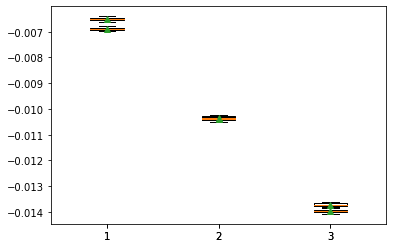

In [1150]:
plt.boxplot(norm_result['twap_mean_pnl'][1:4], showmeans=True)
plt.boxplot(norm_result['signature_mean_pnl'][1:4], showmeans=True,)

public dataset:

In [1155]:
norm_result[4:7]

,twap_mean_pnl,signature_mean_pnl,lots_count,data_points,twap_type
experiment_5,"(-0.004772923320695867, -0.004413104241272259)","(-0.004033229354774254, -0.0034174735679043094)",1000,public,5_by_20%
experiment_6,"(-0.007607739423328643, -0.00723363645532459)","(-0.0040332293547742214, -0.0034174735679042703)",5000,public,5_by_20%
experiment_7,"(-0.010471026885389947, -0.01008155478312662)","(-0.0040332293547742214, -0.0034174735679042703)",10000,public,5_by_20%


{'whiskers': [<matplotlib.lines.Line2D at 0x15e8daa4130>,
 'caps': [<matplotlib.lines.Line2D at 0x15e8daa47f0>,
 'boxes': [<matplotlib.lines.Line2D at 0x15e8da9ad90>,
 'medians': [<matplotlib.lines.Line2D at 0x15e8daa4eb0>,
 'fliers': [<matplotlib.lines.Line2D at 0x15e8dab05b0>,
 'means': [<matplotlib.lines.Line2D at 0x15e8dab0250>,
  <matplotlib.lines.Line2D at 0x15e8dad4940>]}

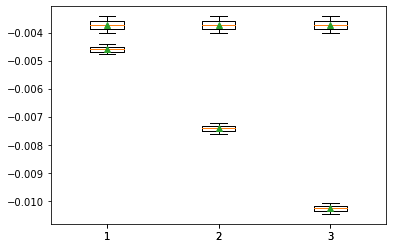

In [1153]:
plt.boxplot(norm_result['twap_mean_pnl'][4:7], showmeans=True)
plt.boxplot(norm_result['signature_mean_pnl'][4:7], showmeans=True)

harder conditions - TWAP uses more steps (10 steps) to hedge:

In [1156]:
norm_result[7:10]

,twap_mean_pnl,signature_mean_pnl,lots_count,data_points,twap_type
experiment_8,"(-0.004244541060911786, -0.003747537185481271)","(-0.004033229354774254, -0.0034174735679043094)",1000,public,10_by_10%
experiment_9,"(-0.005897007803425511, -0.005395311841413703)","(-0.0040332293547742214, -0.0034174735679042703)",5000,public,10_by_10%
experiment_10,"(-0.0075841477223623985, -0.007077912211045232)","(-0.0040332293547742214, -0.0034174735679042703)",10000,public,10_by_10%


{'whiskers': [<matplotlib.lines.Line2D at 0x15e8db80b50>,
 'caps': [<matplotlib.lines.Line2D at 0x15e8db8c250>,
 'boxes': [<matplotlib.lines.Line2D at 0x15e8db807f0>,
 'medians': [<matplotlib.lines.Line2D at 0x15e8db8c910>,
 'fliers': [<matplotlib.lines.Line2D at 0x15e8db8cfd0>,
 'means': [<matplotlib.lines.Line2D at 0x15e8db8cc70>,
  <matplotlib.lines.Line2D at 0x15e8dbbd3d0>]}

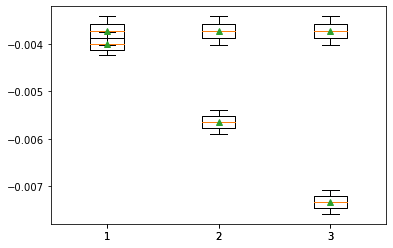

In [1157]:
plt.boxplot(norm_result['twap_mean_pnl'][7:10], showmeans=True)
plt.boxplot(norm_result['signature_mean_pnl'][7:10], showmeans=True)